In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
gwic_filename = '../data/missoula_valley_monitored_wells.csv'
usgs_filename = '../data/clark_fk_above_missoula_q.csv'
gw_df = pd.read_csv(gwic_filename, index_col='time', parse_dates=True)
q_df = pd.read_csv(usgs_filename, index_col='time', parse_dates=True)

In [3]:
df = pd.concat([q_df, gw_df], axis=1, join='inner')

## Data Imputation

### Linear interpolation

In [4]:
# Run 100 times to get average error
for i in range(100):
    
    # Make sure dataset is clean each time
    lin_imputed = df.copy()
    
    # Loop through columns
    for c in np.arange(1, df.shape[1]):

        # Drop preceding NaNs
        first_ind = lin_imputed.iloc[:, c].first_valid_index()
        new_df = lin_imputed.iloc[:, c][first_ind:]

        # Pull out 5 random points for test data
        values_indices = new_df.dropna().index
        test_indices = np.random.choice(values_indices[1:], 5, replace=False)
        test_values = new_df[test_indices]
        new_df.loc[test_indices] = np.nan

        # Linear interpolation
        new_df_int = new_df.interpolate(method='linear')
        new_df_int_ind = new_df_int.index

        # Update dataframe
        lin_imputed.iloc[:, c][new_df_int_ind] = new_df_int

        # Aggregate test data
        test_data = pd.concat([test_values, new_df_int[test_indices]], axis=1)
        test_data.columns = ['value', 'estimate']
        if i == 0 and c == 1:
            lin_test_data = test_data
        else:
            lin_test_data = pd.concat([lin_test_data, test_data], axis=0)

In [5]:
# Calculate error statistics
lin_mae = mean_absolute_error(lin_test_data['value'], lin_test_data['estimate'])
lin_mse = mean_squared_error(lin_test_data['value'], lin_test_data['estimate'])
lin_rmse = np.sqrt(lin_mse)
lin_mape = np.mean(np.abs((lin_test_data['value'] - lin_test_data['estimate']) / lin_test_data['value'])) * 100
lin_rsquared = r2_score(lin_test_data['value'], lin_test_data['estimate'])

lin_error_stats = pd.DataFrame({
    'MAE': lin_mae,
    'MSE': lin_mse,
    'RMSE': lin_rmse,
    'MAPE': lin_mape,
    'R^2': lin_rsquared
}, index=['Linear Interpolation'])

lin_error_stats

,MAE,MSE,RMSE,MAPE,R^2
Linear Interpolation,2.475178,13.90382,3.728783,10.735986,0.955784


<Axes: xlabel='value', ylabel='estimate'>

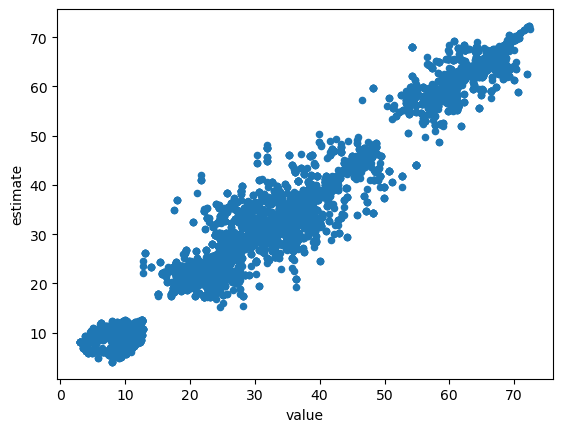

In [6]:
lin_test_data.plot.scatter(x='value', y='estimate')

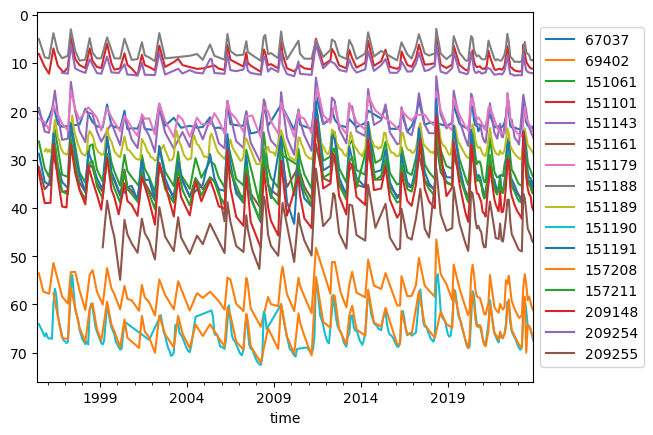

In [7]:
ax = lin_imputed.iloc[:, 1:].plot(legend=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.invert_yaxis()

### Interpolate with time

In [8]:
# Run 100 times to get average error
for i in range(100):
    
    # Make sure dataset is clean each time
    time_imputed = df.copy()
    
    # Loop through columns
    for c in np.arange(1, df.shape[1]):

        # Drop preceding NaNs
        first_ind = time_imputed.iloc[:, c].first_valid_index()
        new_df = time_imputed.iloc[:, c][first_ind:]

        # Pull out 5 random points for test data
        values_indices = new_df.dropna().index
        test_indices = np.random.choice(values_indices[1:], 5, replace=False)
        test_values = new_df[test_indices]
        new_df.loc[test_indices] = np.nan

        # Linear interpolation
        new_df_int = new_df.interpolate(method='time')
        new_df_int_ind = new_df_int.index

        # Update dataframe
        time_imputed.iloc[:, c][new_df_int_ind] = new_df_int

        # Aggregate test data
        test_data = pd.concat([test_values, new_df_int[test_indices]], axis=1)
        test_data.columns = ['value', 'estimate']
        if i == 0 and c == 1:
            time_test_data = test_data
        else:
            time_test_data = pd.concat([time_test_data, test_data], axis=0)

In [9]:
# Calculate error statistics
time_mae = mean_absolute_error(time_test_data['value'], time_test_data['estimate'])
time_mse = mean_squared_error(time_test_data['value'], time_test_data['estimate'])
time_rmse = np.sqrt(time_mse)
time_mape = np.mean(np.abs((time_test_data['value'] - time_test_data['estimate']) / time_test_data['value'])) * 100
time_rsquared = r2_score(time_test_data['value'], time_test_data['estimate'])

time_error_stats = pd.DataFrame({
    'MAE': time_mae,
    'MSE': time_mse,
    'RMSE': time_rmse,
    'MAPE': time_mape,
    'R^2': time_rsquared
}, index=['Time Interpolation'])

time_error_stats

,MAE,MSE,RMSE,MAPE,R^2
Time Interpolation,2.500019,13.945895,3.73442,10.696231,0.955973


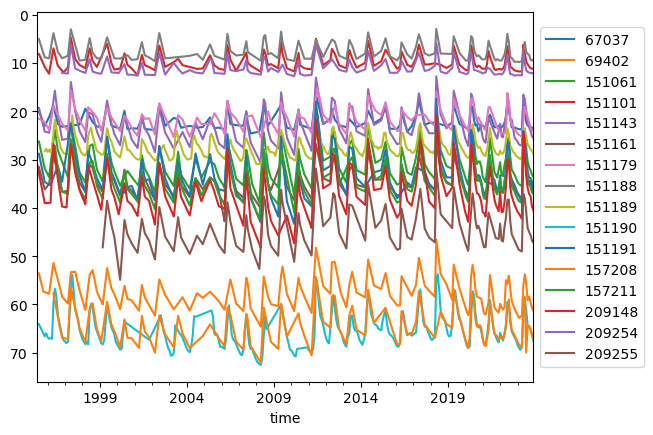

In [10]:
ax = time_imputed.iloc[:, 1:].plot(legend=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.invert_yaxis()

### Seasonal Trend Decomposition using Loess (STL)
Inspired by [Medium blog post](https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7)

In [30]:
# Run 100 times to get average error
for i in range(100):
    
    # Make sure dataset is clean each time
    stl_imputed = df.copy()
    
    # Loop through columns
    for c in np.arange(1, df.shape[1]):
        
        # Drop preceding NaNs
        first_ind = stl_imputed.iloc[:, c].first_valid_index()
        new_df = stl_imputed.iloc[:, c][first_ind:]
        
        # Pull out 5 random points for test data
        values_indices = new_df.dropna().index
        test_indices = np.random.choice(values_indices[1:], 5, replace=False)
        test_values = new_df[test_indices]
        new_df.loc[test_indices] = np.nan

        # Get indices of NaNs
        imputed_indices = new_df.isna().index

        # Need to interpolate because STL doesn't handle NaNs
        # new_df = new_df.ffill()

        # Apply STL decomposition to the groundwater level data
        stl = STL(new_df.interpolate(), seasonal=25, period=12, robust=True)
        res = stl.fit()

        # Extract the seasonal component
        seasonal = res.seasonal
        
        # Created deseasonalized groundwater level data
        df_deseas = new_df - seasonal

        # Interpolate the deseasonalized data
        df_deseas_int = df_deseas.interpolate(method='linear')

        # Add seasonal component back to deseasonalized data
        df_imputed = df_deseas_int + seasonal
        
        # Replace NaNs with imputed data
        stl_imputed.iloc[:, c][imputed_indices] = df_imputed[imputed_indices]
        
        # Aggregate test data
        test_data = pd.concat([test_values, df_imputed[test_indices]], axis=1)
        test_data.columns = ['value', 'estimate']
        if i == 0 and c == 1:
            stl_test_data = test_data
        else:
            stl_test_data = pd.concat([stl_test_data, test_data], axis=0)

In [31]:
# Calculate error statistics
stl_mae = mean_absolute_error(stl_test_data['value'], stl_test_data['estimate'])
stl_mse = mean_squared_error(stl_test_data['value'], stl_test_data['estimate'])
stl_rmse = np.sqrt(stl_mse)
stl_mape = np.mean(np.abs((stl_test_data['value'] - stl_test_data['estimate']) / stl_test_data['value'])) * 100
stl_rsquared = r2_score(stl_test_data['value'], stl_test_data['estimate'])
stl_mape

stl_error_stats = pd.DataFrame({
    'MAE': stl_mae,
    'MSE': stl_mse,
    'RMSE': stl_rmse,
    'MAPE': stl_mape,
    'R^2': stl_rsquared
}, index=['STL Decomposition'])

stl_error_stats


,MAE,MSE,RMSE,MAPE,R^2
STL Decomposition,1.29854,3.882936,1.970517,5.599623,0.987567


<Axes: xlabel='time'>

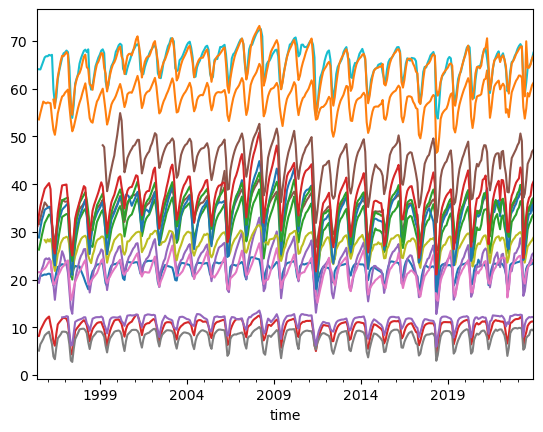

In [32]:
# Plot
stl_imputed.iloc[:, 1:].plot(legend=False)

## Regression imputation using Q and DOY 
Inspired by [Medium blog post](https://medium.com/@aaabulkhair/data-imputation-demystified-time-series-data-69bc9c798cb7)

In [14]:
# Run 100 times to get average error
for i in range(100):
    
    # Make sure dataset is clean each time
    reg_imputed = df.copy()
    
    # Loop through columns
    for c in np.arange(1, df.shape[1]):

        # Drop preceding NaNs
        first_ind = df.iloc[:, c].first_valid_index()
        new_df = df.iloc[:, [0, c]][first_ind:]  
            
        # Pull out 5 random points for test data
        values_indices = new_df.iloc[:, [0, 1]].dropna().index
        test_indices = np.random.choice(values_indices, 5, replace=False)
        test_values = new_df.iloc[:, 1][test_indices]
        new_df.iloc[:, 1].loc[test_indices] = np.nan

        # Get indices of NaNs
        imputed_indices = new_df.iloc[:, 1][new_df.iloc[:, 1].isnull()].index

        # Drop rows with missing values
        df_dropped = new_df.iloc[:, [0, 1]].dropna()    

        # Get predictors (Q and doy) and dependent variable
        X = np.column_stack((df_dropped.Q.values, df_dropped.index.dayofyear.values))
        Y = df_dropped.iloc[:, 1].values

        # Instantiate model
        model = LinearRegression()

        # Fit model
        model.fit(X, Y)

        # Predict missing values
        pred1 = new_df.loc[imputed_indices, 'Q'].values
        pred2 = new_df.loc[imputed_indices, 'Q'].index.dayofyear.values
        preds = np.column_stack((pred1, pred2))
        predicted = model.predict(preds)
        
        # Fill missing values with predicted values
        reg_imputed.iloc[:, c][imputed_indices] = predicted

        # Aggregate test data
        test_data = pd.concat([test_values, reg_imputed.iloc[:, c][test_indices]], axis=1)
        test_data.columns = ['value', 'estimate']
        if i == 0 and c == 1:
            reg_test_data = test_data
        else:
            reg_test_data = pd.concat([reg_test_data, test_data], axis=0)

<Axes: xlabel='value', ylabel='estimate'>

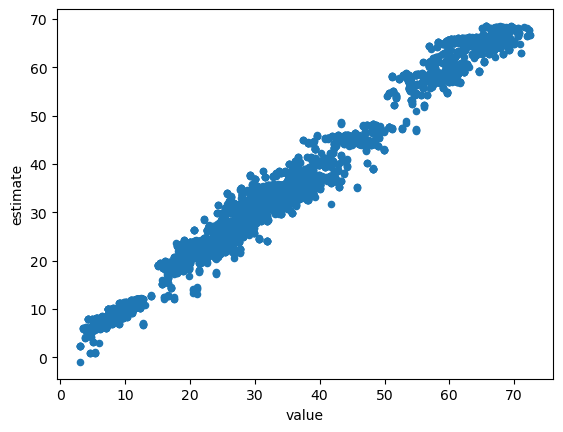

In [15]:
reg_test_data.plot.scatter(x='value', y='estimate')

In [16]:
# Calculate error statistics
reg_mae = mean_absolute_error(reg_test_data['value'], reg_test_data['estimate'])
reg_mse = mean_squared_error(reg_test_data['value'], reg_test_data['estimate'])
reg_rmse = np.sqrt(reg_mse)
reg_mape = np.mean(np.abs((reg_test_data['value'] - reg_test_data['estimate']) / reg_test_data['value'])) * 100
reg_rsquared = r2_score(reg_test_data['value'], reg_test_data['estimate'])
reg_mape

reg_error_stats = pd.DataFrame({
    'MAE': reg_mae,
    'MSE': reg_mse,
    'RMSE': reg_rmse,
    'MAPE': reg_mape,
    'R^2': reg_rsquared
}, index=['Q and DOY Regression'])

reg_error_stats

,MAE,MSE,RMSE,MAPE,R^2
Q and DOY Regression,1.643569,5.12571,2.264003,6.172544,0.983605


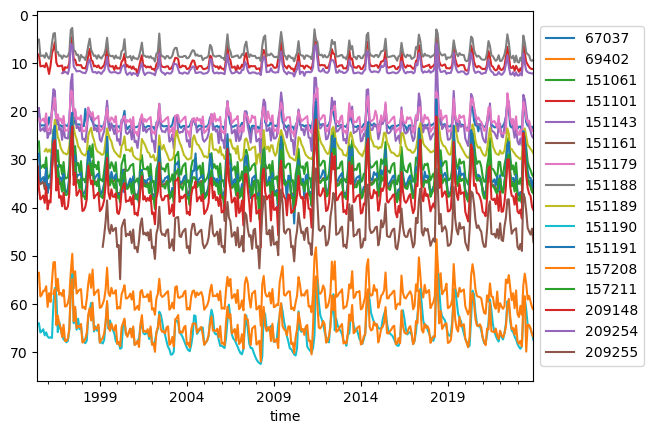

In [17]:
ax = reg_imputed.iloc[:, 1:].plot(legend=False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.invert_yaxis()

### MLR with complete wells

<Axes: xlabel='time'>

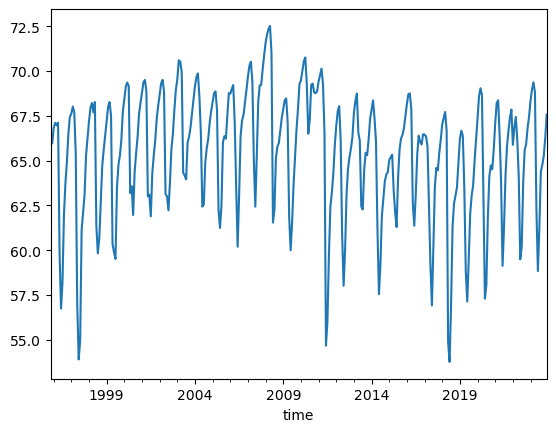

In [29]:

# Make sure dataset is clean each time
wells_imputed = df.copy()
wells_imputed = wells_imputed['1995-11-29':]

# Fill in gaps of well data used as predictors
# wells_imputed[w1_name] = wells_imputed[w1_name].interpolate('linear') 
# wells_imputed[w2_name] = wells_imputed[w2_name].interpolate('linear') 

# wells_imputed['151190'].interpolate('cubic').plot()


# Need to interpolate because STL doesn't handle NaNs
imputed_indices = wells_imputed[wells_imputed.isnull()].index
new_df = wells_imputed['151190']

# Apply STL decomposition to the groundwater level data
stl = STL(new_df.interpolate(), seasonal=25, period=12, robust=True)
res = stl.fit()

# Extract the seasonal component
seasonal = res.seasonal

# Created deseasonalized groundwater level data
df_deseas = new_df - seasonal

# Interpolate the deseasonalized data
df_deseas_int = df_deseas.interpolate(method='linear')

# Add seasonal component back to deseasonalized data
df_imputed = df_deseas_int + seasonal

df_imputed.plot()

In [27]:
imputed_indices

DatetimeIndex(['1995-11-30', '1995-12-31', '1996-01-31', '1996-02-29',
               '1996-03-31', '1996-04-30', '1996-05-31', '1996-06-30',
               '1996-07-31', '1996-08-31',
               ...
               '2023-03-31', '2023-04-30', '2023-05-31', '2023-06-30',
               '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31',
               '2023-11-30', '2023-12-31'],
              dtype='datetime64[ns]', name='time', length=338, freq='M')

In [37]:
w1_name = '151189'
w2_name = '151190'

# Run 100 times to get average error
for i in range(100):
    
    # Make sure dataset is clean each time
    wells_imputed = df.copy()
    wells_imputed = wells_imputed['1995-11-29':]
    
    # Need to fill in gaps of well data used as predictors. Will use STL.
    w1_data = wells_imputed[w1_name] 
    w2_data = wells_imputed[w2_name]
    
    # Apply STL decomposition to the groundwater level data
    stl1 = STL(w1_data.interpolate(), seasonal=25, period=12, robust=True)
    stl2 = STL(w2_data.interpolate(), seasonal=25, period=12, robust=True)
    res1 = stl1.fit()
    res2 = stl2.fit()

    # Extract the seasonal component
    seasonal1 = res1.seasonal
    seasonal2 = res2.seasonal

    # Created deseasonalized groundwater level data
    df_deseas1 = w1_data - seasonal1
    df_deseas2 = w2_data - seasonal2

    # Interpolate the deseasonalized data
    df_deseas_int1 = df_deseas1.interpolate(method='linear')
    df_deseas_int2 = df_deseas2.interpolate(method='linear')

    # Add seasonal component back to deseasonalized data
    wells_imputed[w1_name] = df_deseas_int1 + seasonal1
    wells_imputed[w2_name] = df_deseas_int2 + seasonal2

    # Loop through columns
    for c in np.arange(1, wells_imputed.shape[1]):

        # Get name of well and make sure it is not a predictor well
        cname = wells_imputed.iloc[:, c].name
        if (cname == w1_name) or (cname == w2_name):
            continue
        
        # Drop preceding NaNs
        first_ind = wells_imputed.iloc[:, c].first_valid_index()
        new_df = wells_imputed.loc[:, [w1_name, w2_name, cname]][first_ind:]  
            
        # Pull out 5 random points for test data
        values_indices = new_df.iloc[:, [0, 1, 2]].dropna().index
        test_indices = np.random.choice(values_indices, 5, replace=False)
        test_values = new_df[cname][test_indices]
        new_df[cname].loc[test_indices] = np.nan

        # Get indices of NaNs
        imputed_indices = new_df[cname][new_df[cname].isnull()].index

        # Drop rows with missing values
        df_dropped = new_df.dropna()    

        # Get predictors and dependent variable
        X = np.column_stack((df_dropped[w1_name].values, df_dropped[w2_name].values, df_dropped.index.dayofyear.values))
        Y = df_dropped[cname].values

        # Instantiate model
        model = LinearRegression()

        # Fit model
        model.fit(X, Y)

        # Predict missing values
        pred1 = new_df.loc[imputed_indices, w1_name].values
        pred2 = new_df.loc[imputed_indices, w2_name].values
        pred3 = new_df.loc[imputed_indices, cname].index.dayofyear.values
        preds = np.column_stack((pred1, pred2, pred3))
        predicted = model.predict(preds)
        
        # Fill missing values with predicted values
        wells_imputed[cname][imputed_indices] = predicted

        # Aggregate test data
        test_data = pd.concat([test_values, wells_imputed[cname][test_indices]], axis=1)
        test_data.columns = ['value', 'estimate']
        if i == 0 and c == 1:
            wells_test_data = test_data
        else:
            wells_test_data = pd.concat([wells_test_data, test_data], axis=0)

In [38]:
# Calculate error statistics
wells_mae = mean_absolute_error(wells_test_data['value'], wells_test_data['estimate'])
wells_mse = mean_squared_error(wells_test_data['value'], wells_test_data['estimate'])
wells_rmse = np.sqrt(wells_mse)
wells_mape = np.mean(np.abs((wells_test_data['value'] - wells_test_data['estimate']) / wells_test_data['value'])) * 100
wells_rsquared = r2_score(wells_test_data['value'], wells_test_data['estimate'])
wells_mape

wells_error_stats = pd.DataFrame({
    'MAE': wells_mae,
    'MSE': wells_mse,
    'RMSE': wells_rmse,
    'MAPE': wells_mape,
    'R^2': wells_rsquared
}, index=['Well Regression'])

wells_error_stats

,MAE,MSE,RMSE,MAPE,R^2
Well Regression,0.891882,1.775767,1.332579,4.265469,0.99355


In [39]:
pd.concat([lin_error_stats, 
           stl_error_stats, 
           time_error_stats, 
           reg_error_stats, 
           wells_error_stats], 
          axis=0)

,MAE,MSE,RMSE,MAPE,R^2
Linear Interpolation,2.475178,13.903820,3.728783,10.735986,0.955784
STL Decomposition,1.298540,3.882936,1.970517,5.599623,0.987567
Time Interpolation,2.500019,13.945895,3.734420,10.696231,0.955973
Q and DOY Regression,1.643569,5.125710,2.264003,6.172544,0.983605
Well Regression,0.891882,1.775767,1.332579,4.265469,0.993550
